In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))


from Utilities.utils import *

# Get the current working directory
current_working_dir = os.getcwd()
current_working_dir = '//'.join(current_working_dir.split('\\')[0:-2]) + r'//data/f5//'


dark_pink = '#BE575F'
dark_blue = '#232C56'



Figure 5b

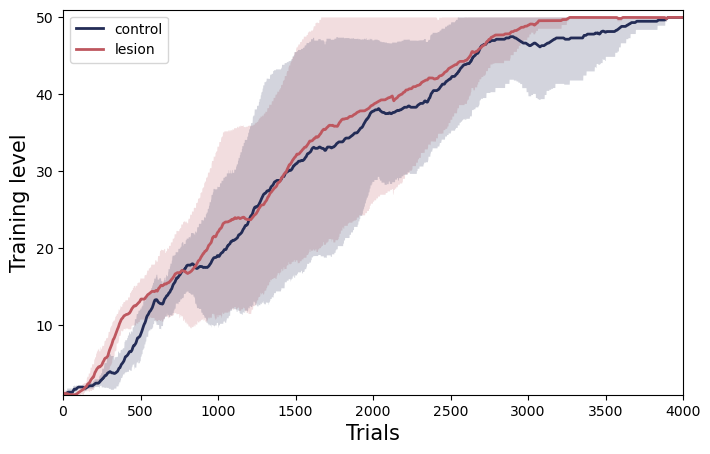

In [2]:
# Read CSV
pl_data = pd.read_csv(current_working_dir + 'hippocampus_learning_curves.csv')


# Extract data
categories = pl_data.catagory.values
animals = pl_data.animal.values
t_levels = parse_training_levels(pl_data.training_levels.values)

# Calculate mean and std for lesion and control groups
lesion_mask = categories == 'lesion'
lesion_MeanLearningCurve, lesion_std = calculate_mean_std(t_levels, lesion_mask)

control_mask = categories == 'control'
control_MeanLearningCurve, control_std = calculate_mean_std(t_levels, control_mask)

# Plot
%matplotlib inline
window = 10
xlim = 4000

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_xlim([0, xlim])
ax.set_ylim([1, 51])

ax.plot(convolve_movmean(control_MeanLearningCurve[:xlim], window), '-', color=dark_blue, linewidth=2,label = 'control')
ax.plot(convolve_movmean(lesion_MeanLearningCurve[:xlim], window), '-', color='#BE575F', linewidth=2, label = 'lesion')

ax.set_xlabel('Trials', fontsize=15)
ax.set_ylabel('Training level', fontsize=15)

fill_between_mean_std(ax, lesion_MeanLearningCurve, lesion_std, '#BE575F',xlim)
fill_between_mean_std(ax, control_MeanLearningCurve, control_std, dark_blue,xlim)

plt.legend(loc="upper left")

In [ ]:
# Set cut-off for number of trials to consider
cut = 4000

# Initialize lists to store data
new, group, cum_trials, animalid = [], [], [], []

# Process each item in t_levels
for index, item in enumerate(t_levels):
    new += item[0:cut]  # Append the first 'cut' elements of the current item
    group += cut * [pl_data.catagory.values[index]]  # Assign group
    animalid += [animals[index]] * cut  # Append animal ID
    cum_trials += list(np.linspace(1, cut, cut))  # Generate cumulative trial numbers

# Create DataFrame with collected data
df = pd.DataFrame({'CumTrials': cum_trials, 'Level': new, 'Group': group, 'ID': animalid})

# Set seaborn color palette
color_palette = [(0.24715576, 0.49918708, 0.57655991), (160/255, 11/255 , 11/255)]
sns.set_palette(color_palette)


# Define function to generate experimental group labels
def generate_eg(list_size, prob, hue_order):
    return [hue_order[0] if random.random() < prob else hue_order[1] for _ in range(list_size)]



# define a 100-trial window to bin the data
XBIN = 100

# Bin trial indices
df["TrialIndexBinned"] = (df.CumTrials.values // XBIN) * XBIN + XBIN / 2

# Group by 'ID', 'Group', 'TrialIndexBinned' and calculate mean
df_bintr = df.groupby(['ID', 'Group', 'TrialIndexBinned']).mean().reset_index()
df_bintr['Performance'] = df_bintr.Level

hue_order = ['control', 'lesion']

# Calculate performance difference between groups
perdif_df = df_bintr[df_bintr.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
            df_bintr[df_bintr.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']

# Select necessary columns
df_colsel = df_bintr[['ID', 'Group', 'TrialIndexBinned', 'Performance']].copy()

# Calculate probability for experimental group
exp_gr = [df_colsel[df_colsel.ID == x].Group.unique()[0] for x in df_colsel.ID.unique()]
cb_prob = sum([x == hue_order[0] for x in exp_gr]) / len(exp_gr)

# Seed for reproducibility
np.random.seed(124321)

# Shuffle results
shuff_res = []

# Shuffle and compute performance differences
NSH = 10000
for _ in tqdm(range(NSH)):
    exp_grs = generate_eg(len(exp_gr), cb_prob,hue_order)
    egs_dict = dict(zip(df_colsel.ID.unique(), exp_grs))
    df_colsel['egs'] = df_colsel.ID.map(egs_dict)
    diff = df_colsel[df_colsel.egs == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
           df_colsel[df_colsel.egs == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
    shuff_res.append(diff)

shrdf = pd.concat(shuff_res)

# Calculate real data performance difference
real_data = df_colsel[df_colsel.Group == hue_order[0]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance'] - \
            df_colsel[df_colsel.Group == hue_order[1]].groupby('TrialIndexBinned').mean(numeric_only=True)['Performance']
real_data *= -1

# Plot results
pos_ci = shrdf.groupby('TrialIndexBinned').quantile(.95)
neg_ci = shrdf.groupby('TrialIndexBinned').quantile(.05)

fig2 = plt.figure(figsize=(8, 5))
plt.axhline(0, ls='dotted', alpha=0.4, color='k')
plt.plot(real_data, color='#BE575F', label='observed data')
plt.plot(pos_ci, linestyle='--', color='#232C56', label='95% ci')
plt.plot(neg_ci, linestyle='--', color='#232C56')

x = pos_ci.reset_index().TrialIndexBinned
y1 = neg_ci.reset_index().Performance
y2 = real_data.reset_index().Performance

plt.fill_between(x, y1, y2, where=y2 <= y1, facecolor='#BE575F', alpha=.3, interpolate=True)
plt.ylabel('Performance difference (levels)')
plt.xlabel('trial number')
plt.legend(loc=(0.75, 0.05), frameon=False)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((0, 4000))

 10%|███████████████████████████▊                                                                                                                                                                                                                                                   | 1028/10000 [00:05<00:58, 154.50it/s]

Figure 5c

In [ ]:
coords = pd.read_csv(current_working_dir+'probe_positions.txt', header=0)

# add the striatum limits
z_limits = [190, 200]
y_limits = [60, 271]
colours_ = ['buffer','#BE575F','#1A79B6','#4F4F4F','k']

# select number of slices to show, rows and cols
n_images = 1
rows = 1
cols = 1

fp = Path(current_working_dir+'probe_positions.txt')
parent = fp.parent

# read the file of points
X1 = coords.x1
Y1 = coords.y1
Z1 = coords.z1
X2 = coords.x2
Y2 = coords.y2
Z2 = coords.z2
Animal_Name = coords.Mouse_name

# select only the fibers used in the analysis
X1 = np.array(list(X1)).astype(float)
Y1 = np.array(list(Y1)).astype(float)
Z1 = np.array(list(Z1)).astype(float)
X2 = np.array(list(X2)).astype(float)
Y2 = np.array(list(Y2)).astype(float)
Z2 = np.array(list(Z2)).astype(float)
Animal_Name = np.array(list(Animal_Name))

# read atlas get slice numbers
atlas = Image.open(current_working_dir +'reference_25um_inverted.tif')
h,w = np.shape(atlas)
# decide on the number of images
step = int(np.floor((z_limits[1] - z_limits[0]) / n_images))
sl_list = list(range(z_limits[0], z_limits[1], step))
sl_list = sl_list[-n_images:]

# Mirror all to the right hemisphere
atlas_mid_point = w/2
for i in range(len(X1)):
    if X1[i] > atlas_mid_point:
        dist_to_center = atlas_mid_point - X1[i]
        X1[i] = atlas_mid_point + dist_to_center
for i in range(len(X2)):
    if X2[i] > atlas_mid_point:
        dist_to_center = atlas_mid_point - X2[i]
        X2[i] = atlas_mid_point + dist_to_center
        
for i in range(len(X1)):
    X1[i] = X1[i]-7
for i in range(len(Y2)):
    X2[i] = X2[i]-7

groups = list(coords.group.values)

# make the plot
fig, ax = plt.subplots(1, 1, figsize=[10,10])
# show striatum outline
str_im = Image.open(current_working_dir+'sagtial_reference_25um_inverted.tif')
ax.imshow(str_im, cmap='gray',alpha = 0.6)

for i in range(len(X1)):
    new_point = extend_line((Z1[i],Z2[i]),(Y1[i],Y2[i]),'positive')
    if groups[i] in [1,3]:
        ax.plot(new_point[0], new_point[-1], 'o-', color=colours_[groups[i]],
                alpha=1, markersize=5, markeredgewidth=1)

a=ax.get_xticks().tolist()
a= [25 * a[i] / 1000 for i in range(len(a))]
ax.set_xticklabels(a, fontsize=18)
a=ax.get_yticks().tolist()
a= [25 * a[i] / 1000 for i in range(len(a))]
ax.set_yticklabels(a, fontsize=18)
ax.set_xlabel('ARA A-P axis (mm)', fontsize=22)
ax.set_ylabel('ARA D-V axis (mm)', fontsize=22)

# Hide the right and top spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.savefig(parent / 'sideview_plot.pdf',
            transparent=True, bbox_inches='tight')

# plot the fibers in the slices
fig2, axs = plt.subplots(rows, cols, figsize=[cols * w/50, rows * h/50])

for c,i in enumerate(sl_list):
    atlas.seek(i)
    axs.imshow(atlas, cmap='gray',alpha = 0.6)
    axs.axis('off')
# fig2.subplots_adjust(wspace=0, hspace=0)
fig2.tight_layout()

# plot the fibers
for c,x in enumerate(Z1):
    # find the index of the slice that this point is closest to
    templist = [np.abs(b - x) for b in sl_list]
    idx = np.argmin(templist)
    new_point = extend_line((X1[c],X2[c]),(Y1[c],Y2[c]),'positive')
    if groups[c] in [1,3]:
        axs.plot(new_point[0], new_point[-1], 'o-', color=colours_[groups[c]],
                alpha=1, markersize=5, markeredgewidth=1)

Figure 1D

In [ ]:
#example
%matplotlib notebook
# Get the f3 working directory
f3_working_dir = os.getcwd()
f3_working_dir = '//'.join(f3_working_dir.split('\\')[0:-2]) + r'//data/f3//'

PP_PATH = f3_working_dir + 'ppseq_output_awake\\'
dat_path = current_working_dir + 'example_mouse_data\\'
        
file = find_example_file(PP_PATH)
        
# set tracking path
for file_ in os.listdir(dat_path + r"\video\tracking\\"):
    if 'task' in file_:
        if not 'clock' in file_:
            tracking_path = os.path.join(dat_path + r"\video\tracking\\",file_) + '\\'
            
                                
data = Load_example_data(PP_PATH, file, tracking_path, dat_path)
timeframe = [68,73.2]
neuron_index = pd.read_pickle(PP_PATH + file + r"\analysis_output\reordered_recolored\\" + 'neuron_index')
colors = pd.read_pickle(PP_PATH + file + r"\analysis_output\reordered_recolored\\" + 'colors')

# plot zoomed example
plot_zoomed_example_raster(data,colors,neuron_index,timeframe)

Figure 1E

In [6]:
#example

# file_path = current_working_dir + 'example_replay_data.json'
# with open(file_path, 'r') as file:
#     example_sleep_data = json.load(file)

# # example_sleep_spikes 
# spikes_df = pd.read_csv(current_working_dir + 'example_replay_spikes.csv')

# # caluclate interval timings and end points
# interval_lengths =[]
# for interval in example_sleep_data['behav_time_interval_start']:
#     interval_lengths+= [np.diff(interval)[0]]
# total_time = sum(interval_lengths)
# interval_end_points = np.cumsum(interval_lengths)



# # 10

# timeframe = [971.3,973.5]



# mask = (spikes_df.timestamp>timeframe[0])*(spikes_df.timestamp<timeframe[-1])
# ## neuron order:

# #define neuron order
# neuron_permute_loc = np.zeros(len(example_sleep_data["neuron_index"]))
# for i in range(len(example_sleep_data["neuron_index"])):
#     neuron_permute_loc[i] = int(list(example_sleep_data["neuron_index"]).index(i))
# neuron_order = neuron_permute_loc[(spikes_df.neuron-1).astype(int)]


# ## plotting:

# fig, ax = plt.subplots(1, 1,figsize=(2, 5))



# # plot background in grey 
# background_keep_mask = []
# for item in spikes_df[mask].sequence_type_adjusted:
#     if item < 0 or item >= 7.0:
#         background_keep_mask.append(True)
#     else:
#         background_keep_mask.append(False)
# background_keep_mask = np.array(background_keep_mask)
# ax.scatter(spikes_df[mask][background_keep_mask].timestamp, neuron_order[mask][background_keep_mask],marker = 'o', s=20, linewidth=0,color = 'lightgrey' ,alpha=0.5)

# # plot spikes without background
# background_remove_mask = spikes_df[mask].sequence_type_adjusted >= 0
# background_remove_mask = (spikes_df[mask].sequence_type_adjusted >= 0)*(spikes_df[mask].sequence_type_adjusted != 7.0)*(spikes_df[mask].sequence_type_adjusted != 8.0)
# c_ = np.array(colors)[spikes_df[mask][background_remove_mask].sequence_type_adjusted.values.astype(int)]
# # ## faster:
# ax.scatter(spikes_df[mask][background_remove_mask].timestamp, neuron_order[mask][background_remove_mask],marker = 'o', s=20, linewidth=0,color = c_ ,alpha=1)
# ax.set_title('held sequences in colour and extra sequences + background in grey')




# [1198,1202]

[1198, 1202]

Figure 1F

C:\Users\Emmett\AppData\Local\Temp\ipykernel_4552\3930050558.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.array(data_dict["neuron_rel_forward_replay_positions"])[np.array(bool_) == 1]
C:\Users\Emmett\AppData\Local\Temp\ipykernel_4552\3930050558.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.array(data_dict["neuron_rel_awake_positions_forwards"])[np.array(bool_) == 1]
C:\Users\Emmett\AppData\Local\Temp\ipykernel_4552\3930050558.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a lis

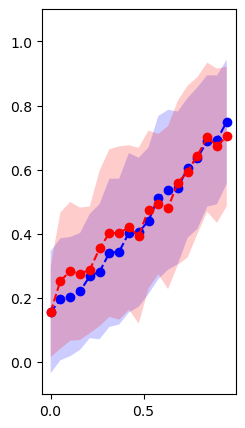

In [7]:


f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'

with open(f4_working_dir+ 'spike_pos_awake_replay.json', 'r') as file:
    data_dict = json.load(file)

bool_ = data_dict["expert"]
# Example XY scatter data (replace this with your actual data)
x = np.array(data_dict["neuron_rel_forward_replay_positions"])[np.array(bool_) == 1]
x = [item for sublist in x for item in sublist]
y = np.array(data_dict["neuron_rel_awake_positions_forwards"])[np.array(bool_) == 1]
y = [item for sublist in y for item in sublist]

bool_ = data_dict["h_lesion"]
x2 = np.array(data_dict["neuron_rel_forward_replay_positions"])[np.array(bool_) == 1]
x2 = [item for sublist in x2 for item in sublist]
y2 = np.array(data_dict["neuron_rel_awake_positions_forwards"])[np.array(bool_) == 1]
y2 = [item for sublist in y2 for item in sublist]

# Plot
fig, ax = plt.subplots(1, 1,figsize=(2.5, 5))

xdat = [x,x2]
ydat = [y,y2]
num_bins = 20
bins_ = []
means_ = []
for i, col in enumerate(['blue','red']):
    means,sems,bins,binned_x = bin_position_data(xdat[i],ydat[i],num_bins)
    ax.plot(bins,means,'o--', c = col)
    upper = np.array(means) + np.array(sems)
    lower = np.array(means) - np.array(sems)
    ax.fill_between(sorted(bins),(lower),(upper),
        alpha=0.2, edgecolor='None', facecolor=col,
        linewidth=1, linestyle='dashdot', antialiased=True)
    bins_+=[bins]
    means_+=[means]

    ax.set_ylim(-0.1,1.1)



Figure 1G

In [8]:
#example
# [1494,1499]

Figure 1H

2
3
6
4
5
2
3
4
5


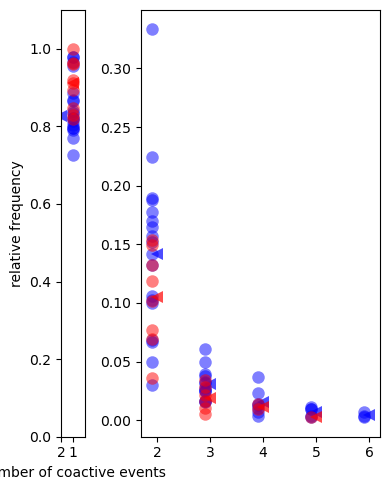

In [9]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
file_path = f4_working_dir + 'all_recordings_replay_feature_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)
    
e_coactive_freqs_counts = data['e_coactive_freqs_counts']

fig, [ax,ax2]= plt.subplots(1, 2,figsize=(4, 5),gridspec_kw={'width_ratios': [1, 10]})

plot_coactive_props(ax,ax2, data['e_coactive_freqs_counts'],'blue')
plot_coactive_props(ax,ax2, data['hl_coactive_freqs_counts'],'red')



In [10]:
##STATS

e_coactive_freqs_counts = data['e_coactive_freqs_counts']
hl_coactive_freqs_counts= data['hl_coactive_freqs_counts']
df = pd.DataFrame()
df['groups'] = ['control']*len(e_coactive_freqs_counts['1'])  + ['lesion']*len(hl_coactive_freqs_counts['1'])
for key in e_coactive_freqs_counts:
    current_var = e_coactive_freqs_counts[key]
    while len(current_var)<len(e_coactive_freqs_counts['1']):
        current_var +=[0] 
    try:
        hl_coactive_freqs_counts[key]
        current_var_l = hl_coactive_freqs_counts[key]
        while len(current_var_l)<len(hl_coactive_freqs_counts['1']):
            current_var_l +=[0]
    except:
        current_var_l = [0]*len(hl_coactive_freqs_counts['1'])   
    df[str(key)] = current_var + current_var_l
    
# Calculate the Euclidean distance matrix
values = df[['1', '2', '3', '4', '5', '6']].values
grouping = df['groups'].values

pairwise_distances = pdist(values, metric='euclidean')
distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=10000)
print(results)


method name               PERMANOVA
test statistic name        pseudo-F
sample size                      27
number of groups                  2
test statistic             3.310997
p-value                    0.063194
number of permutations        10000
Name: PERMANOVA results, dtype: object


Figure 1I

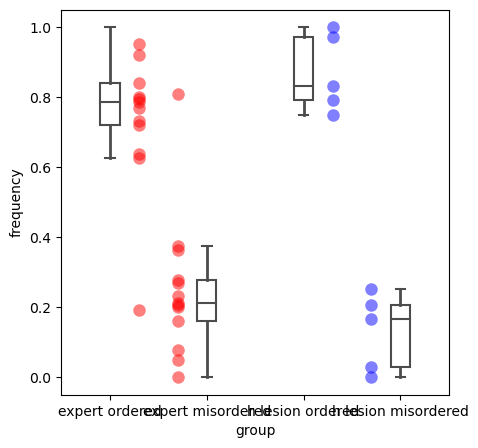

In [11]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
file_path = f4_working_dir + 'all_recordings_replay_feature_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)

ordered_misordered_bdown =[]
for item in data["mouse_summed_amounts"]:
    ordered_misordered_bdown += [list(np.array(item[0:4])/sum(item[0:4]))]
    
e_ordered = []
e_misordered = []
hl_ordered = []
hl_misordered = []
for index,item in enumerate(ordered_misordered_bdown):
    if len(item) > 0:
        if data["expert"][index] == 1:
            if index < 28: # ignore ones from other expert experiment (opto stim mice)
                e_ordered += [sum(item[0:3])]
                e_misordered += [item[-1]]    
        elif data["hlesion"][index] == 1:
            hl_ordered += [sum(item[0:3])]
            hl_misordered += [item[-1]]

fig, ax= plt.subplots(1, 1,figsize=(5, 5))

ax.plot(0.3*np.ones(len(e_ordered[0:-1])),e_ordered[0:-1], 'o', color = 'red', alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(0.7*np.ones(len(e_misordered)),e_misordered, 'o', color = 'red', alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(2.3*np.ones(len(hl_ordered)),hl_ordered, 'o', color = 'blue', alpha = 0.5, markeredgewidth = 0, markersize = 9)
ax.plot(2.7*np.ones(len(hl_misordered)),hl_misordered, 'o', color = 'blue', alpha = 0.5, markeredgewidth = 0, markersize = 9)


data = e_ordered+ e_misordered+hl_ordered+hl_misordered
groups = ['expert ordered'] * len(e_ordered) + ['expert misordered'] * len(e_misordered) + ['h lesion ordered'] * len(hl_ordered) + ['h lesion misordered'] * len(hl_misordered) 
plt_df = pd.DataFrame({'group':groups,'frequency': data })
ax=sns.boxplot( y = 'frequency', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

Observed Test Statistic: 0.7388082284935923
99 percentile: 0.5220480668756532
p-value: 0.00365


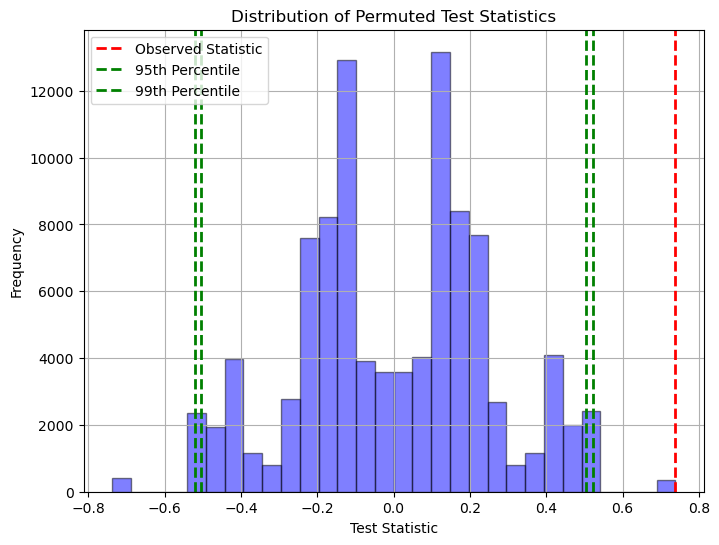

In [12]:
### STATS

list1 = hl_ordered
list2 = hl_misordered


# Define your test statistic function
def test_statistic(list1, list2):
    return np.mean(list1) - np.mean(list2)

# Compute the observed test statistic
observed_statistic = test_statistic(list1, list2)

# Combine the two lists
combined_data = list1 + list2

# Number of permutations
num_permutations = 100000

# Initialize an array to store the permuted test statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test
for i in range(num_permutations):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    
    # Split the shuffled data back into two lists
    permuted_list1 = combined_data[:len(list1)]
    permuted_list2 = combined_data[len(list1):]
    
    # Compute the test statistic for the permuted data
    permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

# Calculate the p-value
p_value = np.mean(permuted_statistics >= observed_statistic)

print("Observed Test Statistic:", observed_statistic)
print("99 percentile:", np.percentile(permuted_statistics, 99))
print("p-value:", p_value)


plt.figure(figsize=(8, 6))
plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Permuted Test Statistics')
plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Test Statistic')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
group1 = e_ordered + hl_ordered
group2 = e_misordered + hl_misordered
grouping = ['control'] * len(e_ordered) + ['lesion'] * len(hl_ordered)

stacked_list = [list(pair) for pair in zip(group1, group2)]

# data is stacked so that each row is a sample (animal) and each colum is a variable/test



pairwise_distances = pdist(stacked_list, metric='euclidean')
distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=999)
print(results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  2
test statistic             1.494755
p-value                       0.251
number of permutations          999
Name: PERMANOVA results, dtype: object


Figure 1J

255_1_1
255_1_2
255_1_4
256_1_1
262_1_1
262_1_2
262_1_4
262_1_5
262_1_6


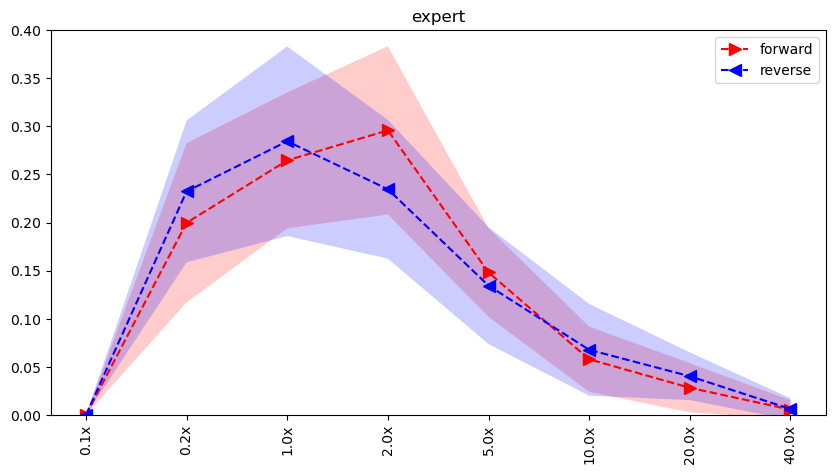

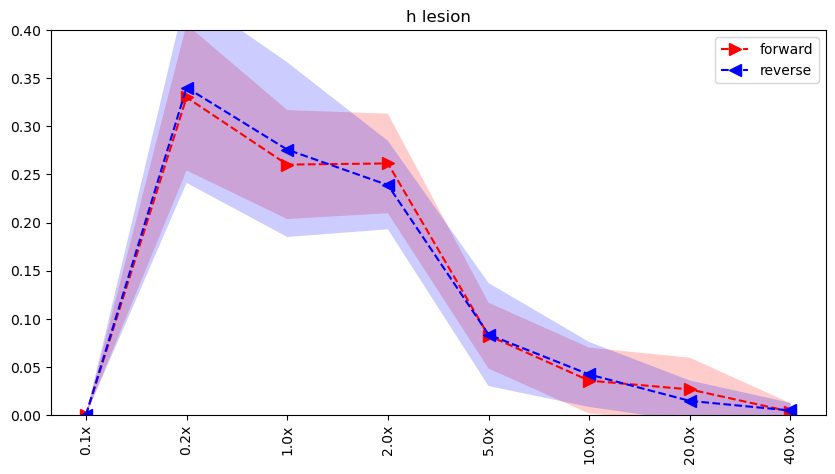

In [14]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
regression_df = pd.read_csv(f4_working_dir + 'warps_df.csv')

sleep_time_point_df = pd.read_csv(f4_working_dir + 'sleep_time_points.csv')
expert_mice = sleep_time_point_df[sleep_time_point_df.group == 'expert'].mir.values
hlesion_mice = sleep_time_point_df[sleep_time_point_df.group == 'h_lesion'].mir.values

bins_ = [0.1, 0.2, 1,2, 5, 10,20,40]

e_f_warp_factors = []
e_r_warp_factors = []
hl_f_warp_factors = []
hl_r_warp_factors = []
l_f_warp_factors = []
l_r_warp_factors = []

e_forward = []
e_reverse = []
hl_forward = []
hl_reverse = []
l_forward = []
l_reverse = []

ef_data = []
er_data = []
hlf_data = []
hlr_data = []
lf_data = []
lr_data = []

for mouse, group in regression_df.groupby('mouse'):
    if mouse in expert_mice:

        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        ef_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        e_f_warp_factors +=[list(example_totals.values())]
        e_forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        er_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        e_r_warp_factors +=[list(example_totals.values())]
        e_reverse += [sum(example_totals.values())]
    elif mouse in hlesion_mice:
        print(mouse)
        #forward:
        data = list(group.warp_factor.values[group.warp_factor.values > 0])
        hlf_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        hl_f_warp_factors +=[list(example_totals.values())]
        hl_forward += [sum(example_totals.values())]
        #reverse:
        data = list(abs(group.warp_factor.values[group.warp_factor.values < 0]))
        hlr_data += data
        closest_examples,example_totals = find_closest_example(data,bins_)
        hl_r_warp_factors +=[list(example_totals.values())]
        hl_reverse += [sum(example_totals.values())]

        
e_f_warp_factors = relative_warp_values(e_f_warp_factors)
e_r_warp_factors = relative_warp_values(e_r_warp_factors)
hl_f_warp_factors = relative_warp_values(hl_f_warp_factors)
hl_r_warp_factors = relative_warp_values(hl_r_warp_factors)


    
fig,ax = plt.subplots(1, 1,figsize=(10, 5))
e_data_f,e_data_r = plot_warps(e_f_warp_factors,e_r_warp_factors,ax,'expert',bins_)
fig,ax1 = plt.subplots(1, 1,figsize=(10, 5))
hl_data_f,hl_data_r = plot_warps(hl_f_warp_factors,hl_r_warp_factors,ax1,'h lesion',bins_)


In [15]:
##stats
# PERMANOVA forward vs reverse diff

grouping = ['control_forwards']*len(np.vstack(hl_f_warp_factors)) + ['control_reverse']*len(np.vstack(hl_r_warp_factors))

stacked_list = [list(pair) for pair in zip(group1, group2)]

# data is stacked so that each row is a sample (animal) and each colum is a variable/test

pairwise_distances = pdist(np.asarray(hl_f_warp_factors+hl_r_warp_factors), metric='euclidean')
distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)

# Perform PERMANOVA
results = permanova(dm, grouping, permutations=10000)
print(results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  2
test statistic             0.208189
p-value                    0.905309
number of permutations        10000
Name: PERMANOVA results, dtype: object


In [16]:
# PERMANOVA forward vs reverse diff

grouping = ['control']*len(np.vstack(e_f_warp_factors)) + ['control']*len(np.vstack(e_r_warp_factors)) + ['lesion']*len(np.vstack(hl_f_warp_factors)) + ['lesion']*len(np.vstack(hl_r_warp_factors))
# data is stacked so that each row is a sample (animal) and each colum is a variable/test

pairwise_distances = pdist(np.asarray(e_f_warp_factors+e_r_warp_factors+hl_f_warp_factors+hl_r_warp_factors), metric='euclidean')

distance_matrix = squareform(pairwise_distances)
dm = DistanceMatrix(distance_matrix)
# Perform PERMANOVA
results = permanova(dm, grouping, permutations=10000)
print(results)

method name               PERMANOVA
test statistic name        pseudo-F
sample size                      52
number of groups                  2
test statistic             8.619178
p-value                      0.0001
number of permutations        10000
Name: PERMANOVA results, dtype: object


In [17]:
# Perform pairwise PERMANOVA on each feature with Bonferroni correction
feature_results = pairwise_permanova_by_feature(np.asarray(e_f_warp_factors+e_r_warp_factors+hl_f_warp_factors+hl_r_warp_factors), np.array(grouping))


print("Feature-wise Pairwise Results:")
for feature_index, group1, group2, result in feature_results:
    if result['p-value'] < 0.05:
        if result["test statistic"] > 0:
            print(f"Feature {feature_index}: Comparison: {group1} vs {group2}")
            print(f"P-value (corrected): {result['p-value']}")
            print(result)
            print('-------------------------------')
            if result['p-value'] < 0.001:
                print('***')
            elif result['p-value'] < 0.01:
                print('**')
            else:
                print('*')
            print('______')



C:\Users\Emmett\anaconda3\lib\site-packages\skbio\stats\distance\_permanova.py:129: RuntimeWarning: invalid value encountered in double_scalars
  return (s_A / (num_groups - 1)) / (s_W / (sample_size - num_groups))


Feature-wise Pairwise Results:
Feature 1: Comparison: control vs lesion
P-value (corrected): 0.0015998400159984002
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      52
number of groups                  2
test statistic            23.290949
p-value                      0.0016
number of permutations        10000
Name: PERMANOVA results, dtype: object
-------------------------------
**
______
Feature 4: Comparison: control vs lesion
P-value (corrected): 0.0031996800319968005
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      52
number of groups                  2
test statistic            14.587485
p-value                      0.0032
number of permutations        10000
Name: PERMANOVA results, dtype: object
-------------------------------
**
______


Figure 1K

(0.0, 0.4)

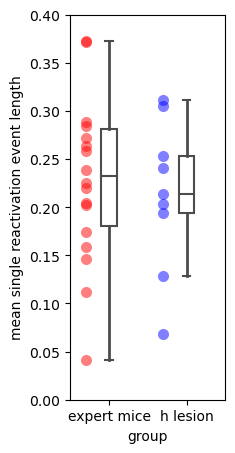

In [18]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
file_path = f4_working_dir + 'all_recordings_replay_feature_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)

e_mean_lens = []
hl_mean_lens = [] 
l_mean_lens = [] 
for index,events in enumerate(data["event_lens"]):
    if data["expert"][index] == 1:
        e_mean_lens += [np.mean(events)]
    elif data["hlesion"][index] == 1:
        hl_mean_lens += [np.mean(events)]


# Create figure and axes
fig, ax= plt.subplots(1, 1,figsize=(2, 5))

# Plot non shuffle data scatter plot
ax.plot(np.ones(len(e_mean_lens))*-0.3, e_mean_lens, 'o',color='red', alpha=0.5, label='Data', markeredgewidth = 0, markersize = 8)
ax.plot(np.ones(len(hl_mean_lens))*0.7, hl_mean_lens, 'o',color='blue', alpha=0.5, label='Data',markeredgewidth = 0, markersize = 8)

plt_df = pd.DataFrame({'group':['expert mice']*len(e_mean_lens) + ['h lesion']*len(hl_mean_lens)+['early learning']*len(l_mean_lens),'mean single reactivation event length': e_mean_lens+hl_mean_lens+l_mean_lens })
ax=sns.boxplot( y = 'mean single reactivation event length', x = 'group', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_ylim(0,0.4)

In [19]:
#stats
group1 = e_mean_lens
group2 = hl_mean_lens

# Shapiro-Wilk Test for Normality
stat1, p1 = shapiro(group1)
stat2, p2 = shapiro(group2)

print("Shapiro-Wilk Test for Normality:")
print("Group 1 - Statistic:", stat1, " p-value:", p1)
print("Group 2 - Statistic:", stat2, " p-value:", p2)

# Interpretation
alpha = 0.05
if p1 > alpha and p2 > alpha:
    print("\nBoth groups are normally distributed.")
    print(scipy.stats.ttest_ind(group1,group2))
else:
    print("\nAt least one group is not normally distributed.")
    stat, p = mannwhitneyu(group1, group2)
    print("Statistic:", stat, " p-value:", p)

Shapiro-Wilk Test for Normality:
Group 1 - Statistic: 0.9777160286903381  p-value: 0.923430323600769
Group 2 - Statistic: 0.9486023187637329  p-value: 0.6747228503227234

Both groups are normally distributed.
Ttest_indResult(statistic=0.6701066248505064, pvalue=0.5089328821054988)


Figure 1L

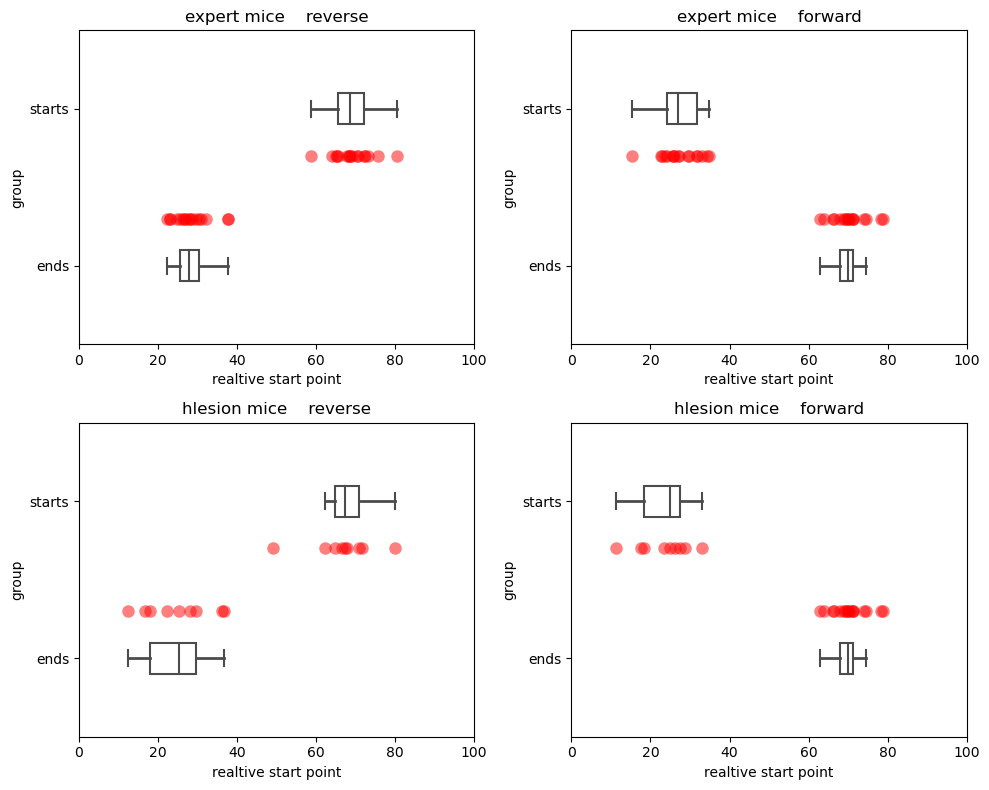

In [20]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
start_end_df = pd.read_csv(f4_working_dir + "start_end_df.csv")
expert_mice = sleep_time_point_df[sleep_time_point_df.group == 'expert'].mir.values

e_all_chunk_forward_start_mean = []
e_all_chunk_forward_end_mean = []
e_all_chunk_reverse_start_mean = []
e_all_chunk_reverse_end_mean = []
hl_all_chunk_forward_start_mean = []
hl_all_chunk_forward_end_mean = []
hl_all_chunk_reverse_start_mean = []
hl_all_chunk_reverse_end_mean = []
# s_o_d = []
for mouse,group in start_end_df.groupby('mouse'):
    chunk_forward_start_mean = []
    chunk_forward_end_mean = []
    chunk_reverse_start_mean = []
    chunk_reverse_end_mean = []
    for diff, chunk in group.groupby('sleep_onset_diff'):
        forward_chunk = chunk[chunk.label == 'forward']
        chunk_forward_start_mean += [np.mean(forward_chunk[forward_chunk.group == 'starts']['distances (%)'].values)]
        chunk_forward_end_mean += [np.mean(forward_chunk[forward_chunk.group == 'ends']['distances (%)'].values)]

        reverse_chunk = chunk[chunk.label == 'reverse']
        chunk_reverse_start_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'starts']['distances (%)'].values)]
        chunk_reverse_end_mean += [np.mean(reverse_chunk[reverse_chunk.group == 'ends']['distances (%)'].values)]   
    if mouse in expert_mice:
        e_all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        e_all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        e_all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        e_all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]    
    elif mouse in hlesion_mice:
        hl_all_chunk_forward_start_mean += [np.mean(chunk_forward_start_mean)]
        hl_all_chunk_forward_end_mean += [np.mean(chunk_forward_end_mean)]
        hl_all_chunk_reverse_start_mean += [np.mean(chunk_reverse_start_mean)]
        hl_all_chunk_reverse_end_mean += [np.mean(chunk_reverse_end_mean)]

    
fig,[(ax,ax2),(ax3,ax4)] = plt.subplots(2, 2,figsize=(10, 8))

plot_start_end_times(e_all_chunk_reverse_start_mean,e_all_chunk_forward_start_mean,e_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax,ax2,'expert mice')
plot_start_end_times(hl_all_chunk_reverse_start_mean,hl_all_chunk_forward_start_mean,hl_all_chunk_reverse_end_mean,e_all_chunk_forward_end_mean,ax3,ax4,'hlesion mice')


plt.tight_layout()

In [21]:
#stats

group1 = e_all_chunk_forward_start_mean
group2 = e_all_chunk_forward_end_mean
group3 = e_all_chunk_reverse_start_mean
group4 = e_all_chunk_reverse_end_mean
group5 = hl_all_chunk_forward_start_mean
group6 = hl_all_chunk_forward_end_mean
group7 = hl_all_chunk_reverse_start_mean
group8 = hl_all_chunk_reverse_end_mean

for group in [group1,group2,group3,group4,group5,group6,group7,group8]:
    s,p = stats.shapiro(group)
    print(p)
    if p < 0.05:
        print('non paramteric')
        break
        
data = {
    'group': ['control']*len(group1)+['lesion']*len(group5),
    'forward_start': group1+group5,
    'forward_end': group2+group6,
    'reverse_start': group3+group7,
    'reverse_end': group4+group8,
}
df = pd.DataFrame(data)

# Perform MANOVA
manova = MANOVA.from_formula('forward_start + forward_end +reverse_start +reverse_end  ~ group', data=df)
print(manova.mv_test())

0.5308094620704651
0.6125282049179077
0.8664083480834961
0.148261159658432
0.8534241914749146
0.2505609095096588
0.3598948121070862
0.7146234512329102
                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept         Value   Num DF  Den DF F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda   0.0085 4.0000 21.0000 610.6890 0.0000
         Pillai's trace   0.9915 4.0000 21.0000 610.6890 0.0000
 Hotelling-Lawley trace 116.3217 4.0000 21.0000 610.6890 0.0000
    Roy's greatest root 116.3217 4.0000 21.0000 610.6890 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
            group          Value  Num DF  Den DF F Value Pr > F
------------------------------------

Figure 1M

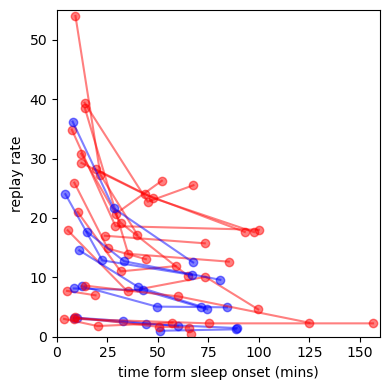

In [22]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
start_end_df = pd.read_csv(f4_working_dir + "start_end_df.csv")
file_path = f4_working_dir + 'all_recordings_replay_feature_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)

times = []
rates = []
hl_times = []
hl_rates = []

fig, ax, = plt.subplots(1, 1,figsize=(4, 4))
ax.set_ylabel('replay rate')
ax.set_xlabel('time form sleep onset (mins)')


for i,item in enumerate(data["event_rate_binned"]):
    across_chunks_x = []
    across_chunks_y = []
    for e,chunk_item in enumerate(item):
        x = data["er_bins_relative_to_so"][i][e]
        y = chunk_item
        
        #mean for each time series across chunks
        across_chunks_x += [np.mean(data["er_bins_relative_to_so"][i][e])]
        across_chunks_y += [np.mean(chunk_item)]
        
    rate_change_per_min = np.diff(across_chunks_y)/np.diff(across_chunks_x)
    if data["expert"][i] == 1:
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = 'red', alpha = 0.5)
        times += across_chunks_y[0:-1]
        rates += list(rate_change_per_min)
    elif data["hlesion"][i] == 1:
        ax.plot(across_chunks_x,across_chunks_y, '-o',c = 'blue', alpha = 0.5) 
        hl_times += across_chunks_y[0:-1]
        hl_rates += list(rate_change_per_min)
        
        

    

ax.set_ylim(0,55)
ax.set_xlim(0,160)
plt.tight_layout()




In [23]:
group1_data = {'x': times, 'y': rates}
group2_data = {'x': hl_times, 'y': hl_rates}

df1 = pd.DataFrame(group1_data)
df2 = pd.DataFrame(group2_data)

# Combine the data into one DataFrame
data = pd.concat([df1, df2], axis=0)

# Create a grouping variable
groups = np.array(['expert'] * len(df1) + ['lesion'] * len(df2))

# Perform MANOVA
manova = MANOVA.from_formula('x + y ~ groups', data=data)

# Print the MANOVA results
print(manova.mv_test())

                 Multivariate linear model
                                                            
------------------------------------------------------------
       Intercept        Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.3093 2.0000 46.0000 51.3529 0.0000
         Pillai's trace 0.6907 2.0000 46.0000 51.3529 0.0000
 Hotelling-Lawley trace 2.2327 2.0000 46.0000 51.3529 0.0000
    Roy's greatest root 2.2327 2.0000 46.0000 51.3529 0.0000
------------------------------------------------------------
                                                            
------------------------------------------------------------
         groups         Value  Num DF  Den DF F Value Pr > F
------------------------------------------------------------
          Wilks' lambda 0.8961 2.0000 46.0000  2.6670 0.0802
         Pillai's trace 0.1039 2.0000 46.0000  2.6670 0.0802
 Hotelling-Lawley trace 0.1160 2.0000 46.0

Figure 1N

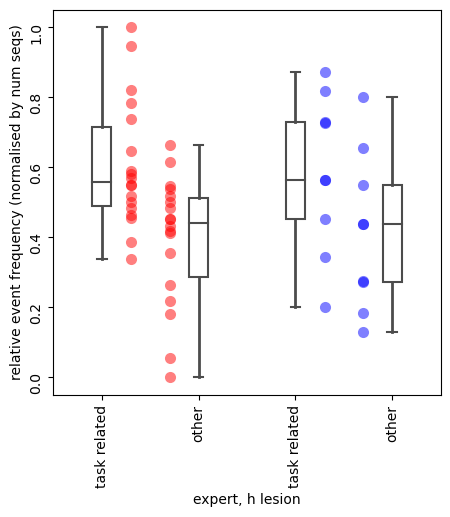

In [24]:
f4_working_dir = os.getcwd()
f4_working_dir = '//'.join(f4_working_dir.split('\\')[0:-2]) + r'//data/f4//'
file_path = f4_working_dir + 'all_recordings_replay_feature_data.json'

with open(file_path, 'r') as file:
    data = json.load(file)

# seq proportions (task seqs vs others) - mean across all
fig, ax= plt.subplots(1, 1,figsize=(5, 5))
e_rel_task_nontask = []
hl_rel_task_nontask = []
l_rel_task_nontask = []
for index,item in enumerate(data["rel_task_nontask"]):
    if data["expert"][index] == 1:
        e_rel_task_nontask += [item]
    elif data["hlesion"][index] == 1:
        hl_rel_task_nontask += [item]
    
for index,item in enumerate(e_rel_task_nontask):    
    ax.plot([0.3,0.7],item, 'o', color = 'red', alpha = 0.5, label='Data', markeredgewidth = 0, markersize = 8)
for index,item in enumerate(hl_rel_task_nontask):    
    ax.plot([2.3,2.7],item, 'o', color = 'blue', alpha = 0.5 , label='Data', markeredgewidth = 0, markersize = 8)
    
data = conactinate_nth_items(e_rel_task_nontask)[0] + conactinate_nth_items(e_rel_task_nontask)[1] + conactinate_nth_items(hl_rel_task_nontask)[0] + conactinate_nth_items(hl_rel_task_nontask)[1] 
groups = (['task related'] * len(conactinate_nth_items(e_rel_task_nontask)[0])) + (['other'] * len(conactinate_nth_items(e_rel_task_nontask)[1])) +  (['task related2'] * len(conactinate_nth_items(hl_rel_task_nontask)[0])) + (['other2'] * len(conactinate_nth_items(hl_rel_task_nontask)[1]))
plt_df = pd.DataFrame({'expert, h lesion':groups,'relative event frequency (normalised by num seqs)': data })
ax=sns.boxplot( y = 'relative event frequency (normalised by num seqs)', x = 'expert, h lesion', data = plt_df, color = 'blue', width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

labels = ['task related', 'other', 'task related', 'other', ]
    
ax.set_xticks(range(0,len(labels)))
ax.set_xticklabels(labels)
ax.tick_params(axis='both', which='major', labelsize=10, rotation =90)


Observed Test Statistic: 0.16970052500484822
p-value: 0.06306


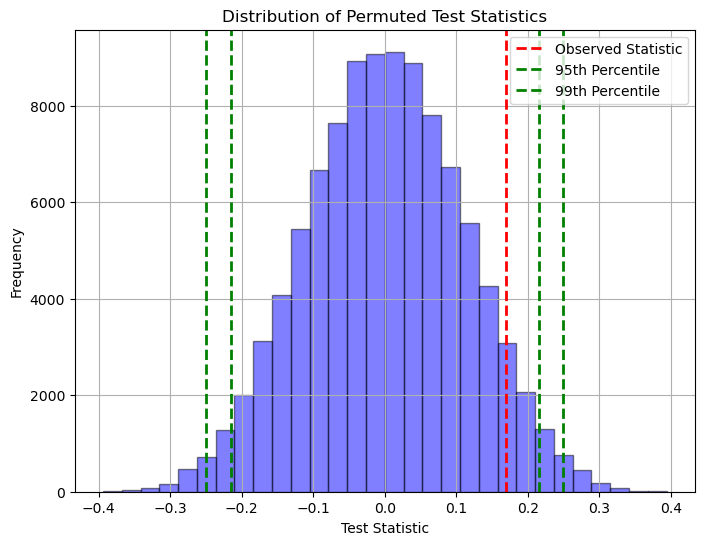

In [25]:
##stats h lesion task related vs other

list1= [item[0] for item in hl_rel_task_nontask]
list2= [item[1] for item in hl_rel_task_nontask]


# Define your test statistic function
def test_statistic(list1, list2):
    return np.mean(list1) - np.mean(list2)

# Compute the observed test statistic
observed_statistic = test_statistic(list1, list2)

# Combine the two lists
combined_data = list1 + list2

# Number of permutations
num_permutations = 100000

# Initialize an array to store the permuted test statistics
permuted_statistics = np.zeros(num_permutations)

# Permutation test
for i in range(num_permutations):
    # Shuffle the combined data
    np.random.shuffle(combined_data)
    
    # Split the shuffled data back into two lists
    permuted_list1 = combined_data[:len(list1)]
    permuted_list2 = combined_data[len(list1):]
    
    # Compute the test statistic for the permuted data
    permuted_statistics[i] = test_statistic(permuted_list1, permuted_list2)

# Calculate the p-value
p_value = np.mean(permuted_statistics >= observed_statistic)

print("Observed Test Statistic:", observed_statistic)
print("p-value:", p_value)


plt.figure(figsize=(8, 6))
plt.hist(permuted_statistics, bins=30, alpha=0.5, color='blue', edgecolor='black')
plt.axvline(observed_statistic, color='red', linestyle='dashed', linewidth=2, label='Observed Statistic')
plt.xlabel('Test Statistic')
plt.ylabel('Frequency')
plt.title('Distribution of Permuted Test Statistics')
plt.axvline(np.percentile(permuted_statistics, 97.5), color='green', linestyle='dashed', linewidth=2, label='95th Percentile')
plt.axvline(np.percentile(permuted_statistics, 2.5), color='green', linestyle='dashed', linewidth=2)
plt.axvline(np.percentile(permuted_statistics, 99), color='green', linestyle='dashed', linewidth=2, label='99th Percentile')
plt.axvline(np.percentile(permuted_statistics, 1), color='green', linestyle='dashed', linewidth=2)
plt.xlabel('Test Statistic')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
# stats, between groups 

stats.shapiro(conactinate_nth_items(e_rel_task_nontask)[1])
stats.shapiro(conactinate_nth_items(hl_rel_task_nontask)[0])

# all are normal, use manova 

from statsmodels.multivariate.manova import MANOVA
data = {
    'group': ['control']*len(conactinate_nth_items(e_rel_task_nontask)[0])+['lesion']*len(conactinate_nth_items(hl_rel_task_nontask)[0]),
    'TASK': conactinate_nth_items(e_rel_task_nontask)[0]+conactinate_nth_items(hl_rel_task_nontask)[0],
    'NONTASK': conactinate_nth_items(e_rel_task_nontask)[1]+conactinate_nth_items(hl_rel_task_nontask)[1],
}
df = pd.DataFrame(data)

# Perform MANOVA
manova = MANOVA.from_formula('TASK + NONTASK ~ group', data=df)
print(manova.mv_test())


                                 Multivariate linear model
                                                                                            
--------------------------------------------------------------------------------------------
       Intercept                Value          Num DF  Den DF         F Value         Pr > F
--------------------------------------------------------------------------------------------
          Wilks' lambda                -0.0000 2.0000 24.0000 -54043195528445968.0000 1.0000
         Pillai's trace                 1.0000 2.0000 24.0000 -54043195528445968.0000 1.0000
 Hotelling-Lawley trace -4503599627370497.0000 2.0000 24.0000 -54043195528445960.0000 1.0000
    Roy's greatest root -4503599627370497.0000 2.0000 24.0000 -54043195528445968.0000 1.0000
--------------------------------------------------------------------------------------------
                                                                                            
-----------